In [1]:
import levin
import numpy as np
import time

Let us define an integral of the type
$$ I(y) = \int j_{\ell_1}(xk_1)j_{\ell_2}(xk_2) f(x) \mathrm{d}x\,, $$
which we integrante from $x=10^{-5}$ to $100$. For the function we assume $f(x) = (x^3 - x^2 + x)x$. Refer to the example in ```test_levin_single.ipynb``` for more details on the individual steps in this tutorial.

In [2]:
x = np.geomspace(1e-5,100,100) #define support
f_of_x = (x**3 -x**2 +x)[:, None]*x[None, :] #define f(x) 

# define integral type for Levin, 0 correpsonds to single spherical Bessel function 
# 0: single spherical Bessel function
# 1: single cylindrical Bessel function
# 2: double spherical Bessel function
# 3: double cylindrical Bessel function
# 4: triple spherical Bessel function
# 5: triple cylindrical Bessel function
integral_type = 2
N_thread = 4 # Number of threads used for hyperthreading
logx = True # Tells the code to create a logarithmic spline in x for f(x)
logy = True # Tells the code to create a logarithmic spline in y for y = f(x)
lp = levin.levin(integral_type, x, f_of_x, logx, logy, N_thread) #Constructor of the class
n_sub = 8 #number of collocation points in each bisection
n_bisec_max = 32 #maximum number of bisections used
rel_acc = 1e-4 #relative accuracy target
boost_bessel = True #should the bessel functions be calculated with boost instead of GSL, higher accuracy at high Bessel orders
verbose = False #should the code talk to you?


In [3]:
N = 1000
k = np.geomspace(1e-2,10000,N)
n_order_1 = 5
n_order_2 = 10
ell_1 = (n_order_1*np.ones_like(k)).astype(int)
ell_2 = (n_order_2*np.ones_like(k)).astype(int)

t0 = time.time()
result_levin = np.zeros((N, 100))
lp.levin_integrate_bessel_double(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,ell_1,ell_2, False, result_levin)
print("Levin took", time.time() -t0, "s")

maximum number of bisections reached for integrand 12 at k_1 0.158928 at k_2 0.158928 and ell_1 5 and ell_2 10
Convergence cannot be reached for the current settings for integrand 12 try to decrease the relative accuracy or increase the possible number of bisections or the number of collocation points.
maximum number of bisections reached for integrand 12 at k_1 0.163385 at k_2 0.163385 and ell_1 5 and ell_2 10
Convergence cannot be reached for the current settings for integrand 12 try to decrease the relative accuracy or increase the possible number of bisections or the number of collocation points.
maximum number of bisections reached for integrand 12 at k_1 0.165661 at k_2 0.165661 and ell_1 5 and ell_2 10
Convergence cannot be reached for the current settings for integrand 12 try to decrease the relative accuracy or increase the possible number of bisections or the number of collocation points.
maximum number of bisections reached for integrand 12 at k_1 0.187617 at k_2 0.187617 an

Levin took 7.361072778701782 s


In [4]:
t0 = time.time()
lp.levin_integrate_bessel_double(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,ell_1,ell_2, False, result_levin)
print("Levin took", time.time() -t0, "s")


Levin took 4.40392279624939 s


In [5]:
t0 = time.time()
lp.levin_integrate_bessel_double(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,ell_1,ell_2, False, result_levin)
print("Levin took", time.time() -t0, "s")


Levin took0.818024
 0.818662166595459 s


Trapeziodal took 43.01779627799988 s


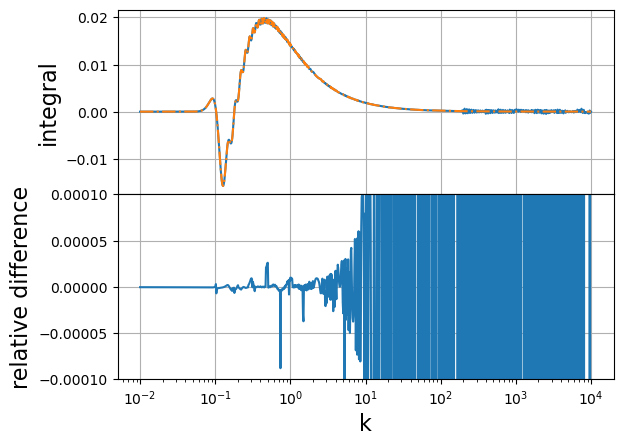

In [6]:
from scipy.special import spherical_jn
import matplotlib.pyplot as plt

trapz_result = np.zeros_like(result_levin)

N_trapz = int(1e5)
trapz_x = np.geomspace(1e-5,100,N_trapz)
trapz_of_x = (trapz_x**3 -trapz_x**2 +trapz_x)[:, None]*x[None, :]

t0 = time.time()
for k_i, k_val in enumerate(k):
    integrand = trapz_of_x* (spherical_jn(n_order_1,k_val*trapz_x)*spherical_jn(n_order_2,k_val*trapz_x))[:, None]
    trapz_result[k_i, :] = np.trapz(integrand, trapz_x, axis = 0)
print("Trapeziodal took", time.time() -t0, "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,trapz_result[:,0]*k**2)
ax[0].semilogx(k,result_levin[:,0]*k**2, ls = "-.")
ax[0].set_ylabel("integral", fontsize = 16)
ax[0].grid(axis = "both")
#ax[0].set_xticks([])

ax[1].semilogx(k, (trapz_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-1e-4,1e-4)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)


Levin took1.08263
 1.0834250450134277 s
Trapeziodal took 42.456223011016846 s


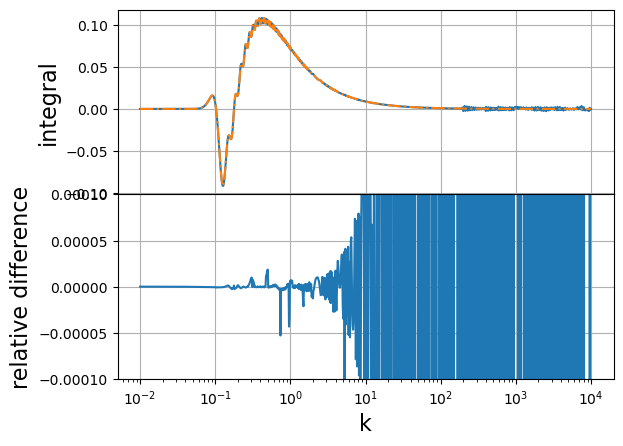

In [7]:
x = np.geomspace(1e-5,100,100)
y = (1.5*x**3.3 -0.69*x**2.5 +x**1.5)[:, None]*x[None, :]
lp.update_integrand(x,y, True, True)

t0 = time.time()
lp.levin_integrate_bessel_double(x[0]*np.ones_like(k),x[-1]*np.ones_like(k),k,k,ell_1,ell_2, False, result_levin)
print("Levin took", time.time() -t0, "s")

trapz_result = np.zeros_like(result_levin)

t0 = time.time()

N_trapz = int(1e5)
trapz_x = np.geomspace(1e-5,100,N_trapz)
trapz_of_x = (1.5*trapz_x**3.3 -0.69*trapz_x**2.5 + trapz_x**1.5)[:, None]*x[None, :]


for k_i, k_val in enumerate(k):
    integrand = trapz_of_x* (spherical_jn(n_order_1,k_val*trapz_x)*spherical_jn(n_order_2,k_val*trapz_x))[:, None]
    trapz_result[k_i, :] = np.trapz(integrand, trapz_x, axis = 0)

print("Trapeziodal took", (time.time() -t0), "s")

fig, ax = plt.subplots(2)
ax[0].semilogx(k,trapz_result[:,0]*k**2)
ax[0].semilogx(k,result_levin[:,0]*k**2, ls = "-.")
ax[0].set_ylabel("integral", fontsize = 16)
ax[0].grid(axis = "both")
#ax[0].set_xticks([])

ax[1].semilogx(k, (trapz_result[:,0] - result_levin[:,0])/result_levin[:,0])
ax[1].set_xlabel("k", fontsize = 16)
ax[1].set_ylabel("relative difference", fontsize = 16)
ax[1].set_ylim(-1e-4,1e-4)
ax[1].grid()
plt.subplots_adjust(wspace=0, hspace=0)

